<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

last updated: 2018-01-31 

CPython 2.7.13
IPython 5.3.0

numpy 1.14.0
matplotlib 2.1.2
scipy 1.0.0
pandas 0.22.0
sklearn 0.19.0
mlxtend 0.7.0


In [2]:
%matplotlib inline
from __future__ import division, print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions

import comptools as comp
    
color_dict = comp.get_color_dict()

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
config = 'IC86.2012'
num_groups = 4
comp_list = comp.get_comp_list(num_groups=num_groups)

# feature_list = ['lap_cos_zenith', 'log_s125', 'log_dEdX', 'avg_inice_radius']
# feature_list, feature_labels = comp.get_training_features(feature_list)
feature_list, feature_labels = comp.get_training_features()
print('Training features = {}'.format(feature_list))

energybins = comp.get_energybins(config=config)
log_energy_min = energybins.log_energy_min
log_energy_max = energybins.log_energy_max

Training features = ['lap_cos_zenith', 'log_s125', 'log_dEdX']


In [4]:
df_sim_train, df_sim_test = comp.load_sim(config=config,
                                          log_energy_min=log_energy_min,
                                          log_energy_max=log_energy_max,
                                          test_size=0.5)

In [5]:
# pipeline_str = 'SVC_comp_{}_{}-groups'.format(config, num_groups)
# pipeline_str = 'NuSVC_comp_{}_{}-groups'.format(config, num_groups)
# pipeline_str = 'LinearSVC_comp_{}_{}-groups'.format(config, num_groups)
# pipeline_str = 'LogisticRegression_comp_{}_{}-groups'.format(config, num_groups)
# pipeline_str = 'RF_comp_{}_{}-groups'.format(config, num_groups)
# pipeline_str = 'BDT_comp_{}_{}-groups'.format(config, num_groups)
# pipeline_str = 'stacking_comp_{}_{}-groups'.format(config, num_groups)
# pipeline_str = 'voting_comp_{}_{}-groups'.format(config, num_groups)
# pipeline_str = 'xgboost_comp_{}_{}-groups'.format(config, num_groups)
pipeline_str = 'linecut_comp_{}_{}-groups'.format(config, num_groups)
pipeline = comp.get_pipeline(pipeline_str)

In [49]:
# # # pipeline.set_params(classifier__booster='gblinear')
# # pipeline.set_params(classifier__booster='gblinear', classifier__subsample=0.5)
# pipeline.set_params(classifier__C=0.5)
pipeline.set_params(classifier__max_depth=2,
                    classifier__subsample=0.5,
                    classifier__reg_alpha=0.5,
                    classifier__n_jobs=5)

Pipeline(memory=None,
     steps=[('classifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=5, nthread=None, objective='binary:logistic', random_state=2,
       reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5))])

In [6]:
X_train, y_train = df_sim_train[feature_list].values, df_sim_train['comp_target_{}'.format(num_groups)].values
X_test, y_test = df_sim_test[feature_list].values, df_sim_test['comp_target_{}'.format(num_groups)].values

In [7]:
clf_name = pipeline.named_steps['classifier'].__class__.__name__
print('=' * 30)
print(clf_name)

pipeline = pipeline.fit(X_train, y_train)
train_pred = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
print('Training accuracy = {:.2%}'.format(train_acc))

test_pred = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
print('Testing accuracy = {:.2%}'.format(test_acc))

print('=' * 30)

LineCutClassifier
Training accuracy = 45.64%
Testing accuracy = 45.87%


In [9]:
# feature_dict =  {'log_s125': 2.0, 'lap_cos_zenith': 0.95}
feature_dict =  {'lap_cos_zenith': 0.95}

In [ ]:
g = sns.JointGrid(x=sim_train_df['log_dEdX'][light_mask & energy_mask],
                  y=sim_train_df['log_dEdX'][light_mask & energy_mask],
                  xlim=(1.5, 2.75), ylim=(100, 160), space=0)


plotting.plot_decision_slice('log_dEdX', 'avg_inice_radius_1_60', sim_train_df[feature_list], pipeline,
                             filler_feature_dict=feature_dict, xres=0.02, yres=0.02, colors=['C0', 'C1'],
                             ax=g.ax_joint)


light_contour = sns.kdeplot(sim_train_df['log_dEdX'][light_mask & energy_mask & zenith_mask],
            sim_train_df['avg_inice_radius_1_60'][light_mask & energy_mask & zenith_mask],
            cmap='Blues', label='light', ax=g.ax_joint)
#             cmap='Blues', label='light', shade=True, shade_lowest=False, alpha=0.5, ax=g.ax_joint)
dE_dX_bins = np.linspace(1.5, 2.75, 50)
inice_radius_bins = np.linspace(100, 160, 50)
_ = g.ax_marg_x.hist(sim_train_df['log_dEdX'][light_mask & energy_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=dE_dX_bins, label='light')
_ = g.ax_marg_y.hist(sim_train_df['avg_inice_radius_1_60'][light_mask & energy_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=inice_radius_bins, orientation="horizontal")


g.x = sim_train_df['log_dEdX'][heavy_mask & energy_mask]
g.y = sim_train_df['avg_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask]
# g = g.plot_joint(sns.kdeplot, cmap='Oranges', label='heavy')
heavy_contour = sns.kdeplot(sim_train_df['log_dEdX'][heavy_mask & energy_mask & zenith_mask],
            sim_train_df['avg_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask],
            cmap='Oranges', label='heavy', ax=g.ax_joint)
#             cmap='Oranges', label='heavy', shade=True, shade_lowest=False, alpha=0.5, ax=g.ax_joint)
_ = g.ax_marg_x.hist(sim_train_df['log_dEdX'][heavy_mask & energy_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=dE_dX_bins, label='heavy')
_ = g.ax_marg_y.hist(sim_train_df['avg_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=inice_radius_bins, orientation="horizontal")

g.ax_joint.grid()
g.ax_marg_x.grid(axis='x')
g.ax_marg_x.legend(loc='upper center', bbox_to_anchor=(0.85, -0.5),
           frameon=False, ncol=1)
g.ax_marg_y.grid(axis='y')

g.ax_joint.set_xlabel('$\mathrm{\\log_{10}(dE/dX)}$')
g.ax_joint.set_ylabel('$\mathrm{\langle R_{\mu}\\rangle }$')
g.ax_joint.text(1.575, 155, '$\mathrm{ 1.5 < \\log_{10}(S_{125}) \leq 1.75 }$', fontsize=12)
# g.ax_joint.text(1.575, 155, '$\mathrm{ 7.5 < \\log_{10}(E_{reco}/GeV) \leq 7.6 }$', fontsize=12)
g.ax_joint.text(1.575, 151, '$\mathrm{ 0.9 < \cos(\\theta_{reco}) \leq 1.0 }$', fontsize=12)

g.savefig('/home/jbourbeau/public_html/figures/avg_inice_radius-vs-dEdX-contours.png')

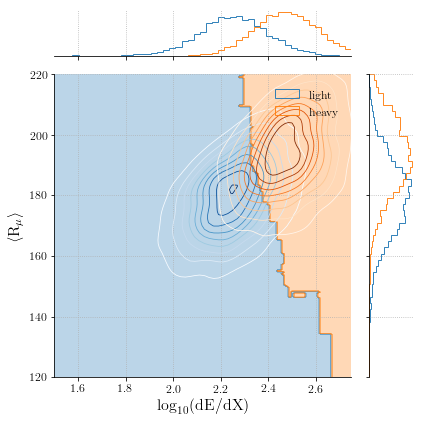

In [24]:
g = sns.JointGrid(x=sim_df_train['log_dEdX'][light_mask & energy_mask],
                  y=sim_df_train['invqweighted_inice_radius_1_60'][light_mask & energy_mask],
                  xlim=(1.5, 2.75), ylim=(120, 220), space=0)


plotting.plot_decision_slice('log_dEdX', 'invqweighted_inice_radius_1_60', sim_df_train[feature_list], pipeline,
                             filler_feature_dict=feature_dict, xres=0.01, yres=0.5, colors=['C0', 'C1'],
                             ax=g.ax_joint)


light_contour = sns.kdeplot(sim_df_train['log_dEdX'][light_mask & energy_mask & zenith_mask],
            sim_df_train['invqweighted_inice_radius_1_60'][light_mask & energy_mask & zenith_mask],
            cmap='Blues', label='light', ax=g.ax_joint)
#             cmap='Blues', label='light', shade=True, shade_lowest=False, alpha=0.5, ax=g.ax_joint)
dE_dX_bins = np.linspace(1.5, 2.75, 50)
inice_radius_bins = np.linspace(120, 220, 50)
_ = g.ax_marg_x.hist(sim_df_train['log_dEdX'][light_mask & energy_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=dE_dX_bins, label='light')
_ = g.ax_marg_y.hist(sim_df_train['invqweighted_inice_radius_1_60'][light_mask & energy_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=inice_radius_bins, orientation="horizontal")


g.x = sim_df_train['log_dEdX'][heavy_mask & energy_mask & zenith_mask]
g.y = sim_df_train['invqweighted_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask]
# g = g.plot_joint(sns.kdeplot, cmap='Oranges', label='heavy')
heavy_contour = sns.kdeplot(sim_df_train['log_dEdX'][heavy_mask & energy_mask & zenith_mask],
            sim_df_train['invqweighted_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask],
            cmap='Oranges', label='heavy', ax=g.ax_joint)
#             cmap='Oranges', label='heavy', shade=True, shade_lowest=False, alpha=0.5, ax=g.ax_joint)
_ = g.ax_marg_x.hist(sim_df_train['log_dEdX'][heavy_mask & energy_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=dE_dX_bins, label='heavy')
_ = g.ax_marg_y.hist(sim_df_train['invqweighted_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=inice_radius_bins, orientation="horizontal")

g.ax_joint.grid()
g.ax_marg_x.grid(axis='x')
g.ax_marg_x.legend(loc='upper center', bbox_to_anchor=(0.85, -0.5),
           frameon=False, ncol=1)
g.ax_marg_y.grid(axis='y')

# g.ax_joint.scatter(sim_train_df['log_dEdX'][light_mask & energy_mask & zenith_mask],
#                    sim_train_df['invqweighted_inice_radius_1_60'][light_mask & energy_mask & zenith_mask],
#                    color='C0', alpha=0.02)
# g.ax_joint.scatter(sim_train_df['log_dEdX'][heavy_mask & energy_mask & zenith_mask],
#                    sim_train_df['invqweighted_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask],
#                    color='C1', alpha=0.02)

g.ax_joint.set_xlabel('$\mathrm{\\log_{10}(dE/dX)}$')
g.ax_joint.set_ylabel('$\mathrm{\langle R_{\mu}\\rangle }$')
# g.ax_joint.text(1.575, 155, '$\mathrm{ 1.5 < \\log_{10}(S_{125}) \leq 1.75 }$', fontsize=12)
# # g.ax_joint.text(1.575, 155, '$\mathrm{ 7.5 < \\log_{10}(E_{reco}/GeV) \leq 7.6 }$', fontsize=12)
# g.ax_joint.text(1.575, 151, '$\mathrm{ 0.9 < \cos(\\theta_{reco}) \leq 1.0 }$', fontsize=12)

g.savefig('/home/jbourbeau/public_html/figures/avg_inice_radius-vs-dEdX-contours.png')

In [10]:
zenith_min = 0.95
zenith_max = 1.0
zenith_mask = (df_sim_train['lap_cos_zenith'] >= zenith_min) & (df_sim_train['lap_cos_zenith'] <= zenith_max)
feature_dict =  {'lap_cos_zenith': np.mean([zenith_min, zenith_max])}
feature_mask = zenith_mask

In [11]:
feature_dict

{'lap_cos_zenith': 0.975}

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


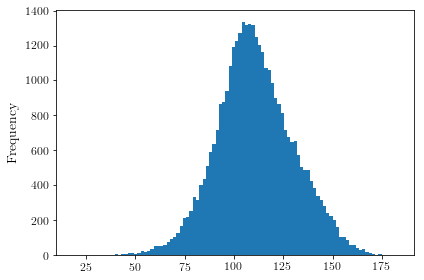

In [10]:
df_sim_train['avg_inice_radius'].plot(kind='hist', bins=100)

In [11]:
df_sim_train['avg_inice_radius'].mean()

110.82490045640594

zenith_min = 0.95
zenith_max = 1.0


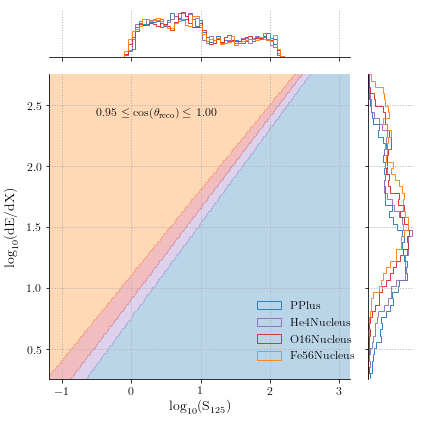

In [9]:
# for zenith_min in [0.8, 0.85, 0.9, 0.95]:
for zenith_min in [0.95]:
    zenith_max = zenith_min + 0.05
    print('zenith_min = {}'.format(zenith_min))
    print('zenith_max = {}'.format(zenith_max))
    zenith_mask = (df_sim_train['lap_cos_zenith'] >= zenith_min) & (df_sim_train['lap_cos_zenith'] <= zenith_max)
    
#     r_min = 100
#     r_max = 110
#     r_mask = (df_sim_train['avg_inice_radius'] >= r_min) & (df_sim_train['avg_inice_radius'] <= r_max)

    feature_dict =  {'lap_cos_zenith': np.mean([zenith_min, zenith_max])}
#                      'avg_inice_radius': np.mean([r_min, r_max])}
    feature_mask = zenith_mask
#     feature_mask = zenith_mask & r_mask

    m = df_sim_train['comp_target_{}'.format(num_groups)] == 0
    g = sns.JointGrid(y=df_sim_train.loc[m, 'log_dEdX'],
                      x=df_sim_train.loc[m, 'log_s125'],
                      ylim=(0.25, 2.75), xlim=(-0.25, 2.25), space=0)

    # Plot decision region using mlxtend
    g.ax_joint = plot_decision_regions(X_train, y_train, clf=pipeline,
                                       feature_index=[1, 2], filler_feature_values={0: np.mean([zenith_min, zenith_max])},
#                                                                                     3: np.mean([r_min, r_max])},
                                       res=0.02, legend=0,
                                       colors=','.join([color_dict[c] for c in comp_list]), hide_spines=False, 
                                       ax=g.ax_joint)

    for composition in comp_list:

        comp_mask = df_sim_train['comp_group_{}'.format(num_groups)] == composition

#         # Contours of light training data
#         counts = sns.kdeplot(df_sim_train['log_s125'][comp_mask & feature_mask],
#                              df_sim_train['log_dEdX'][comp_mask & feature_mask],
#                              cmap=comp.get_colormap(composition), label=composition, ax=g.ax_joint)

        # Histogram of light training data features
        dE_dX_bins = np.linspace(0.25, 2.75, 50)
        s125_bins = np.linspace(-0.25, 2.25, 50)
        _ = g.ax_marg_x.hist(df_sim_train['log_s125'][comp_mask & feature_mask], histtype='step',
                             color=color_dict[composition], alpha=.9, bins=s125_bins, label=composition)
        _ = g.ax_marg_y.hist(df_sim_train['log_dEdX'][comp_mask & feature_mask], histtype='step',
                             color=color_dict[composition], alpha=.9, bins=dE_dX_bins, orientation="horizontal")

    g.ax_joint.grid()
    g.ax_marg_x.grid(axis='x')
    g.ax_marg_y.grid(axis='y')
    g.ax_marg_x.legend(loc='upper center', bbox_to_anchor=(0.85, -5.0),
                       frameon=False, ncol=1)

    g.ax_joint.set_ylabel('$\mathrm{\\log_{10}(dE/dX)}$')
    g.ax_joint.set_xlabel('$\mathrm{\\log_{10}(S_{125})}$')
    g.ax_joint.text(-0.5, 2.4, 
                    '{:0.2f} '.format(zenith_min) + '$\mathrm{ \leq \cos(\\theta_{reco}) \leq }$' + ' {:0.2f}'.format(zenith_max), 
                    fontsize=12)
    
    
#     l_iron = line(s125_bins, 0, 1.1, 2, 2.5)
#     g.ax_joint.plot(s125_bins, l_iron, marker='None', color=color_dict['Fe56Nucleus'])
    
#     l_oxygen = line(s125_bins, 0, 0.9, 2, 2.4)
#     g.ax_joint.plot(s125_bins, l_oxygen, marker='None', color=color_dict['O16Nucleus'])
    
# #     l_helium = line(s125_bins, 0, 0.9, 2, 2.35)
# #     g.ax_joint.plot(s125_bins, l_helium, marker='None', color=color_dict['He4Nucleus'])
    
#     l_proton = line(s125_bins, 0, 0.75, 2, 2.3)
#     g.ax_joint.plot(s125_bins, l_proton, marker='None', color=color_dict['PPlus'])

    outfile = os.path.join(comp.paths.figures_dir, 'model_evaluation',
                           '{}_dEdX-vs-s125-contours_zenith-{:0.2f}-{:0.2f}.png'.format(pipeline_str, 
                                                                                        zenith_min, 
                                                                                        zenith_max))
    g.savefig(outfile)

In [74]:
df_sim_train[feature_list].values[:, 1]

array([0.49803129, 0.05129154, 1.00842331, ..., 0.96314471, 0.33946737,
       1.71848122])

In [53]:
def line(x, x1, y1, x2, y2):
    return (x - x1) * ((y2-y1) / (x2-x1)) + y1

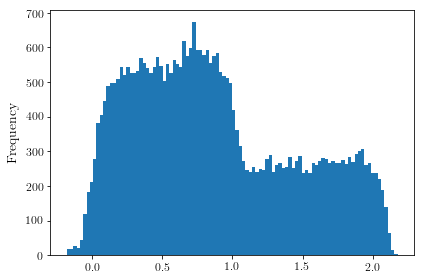

In [21]:
df_sim_train['log_s125'].plot(kind='hist', bins=100)

In [22]:
feature_list

['lap_cos_zenith', 'log_s125', 'log_dEdX', 'avg_inice_radius']

zenith_min = 0.95
zenith_max = 1.0


/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


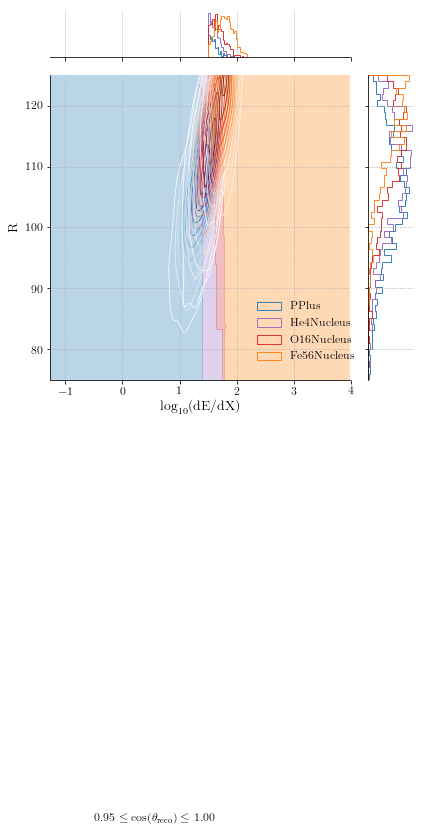

In [27]:
# for zenith_min in [0.95]:
for zenith_min in [0.8, 0.85, 0.9, 0.95]:
    
    zenith_max = zenith_min + 0.05
    print('zenith_min = {}'.format(zenith_min))
    print('zenith_max = {}'.format(zenith_max))
    zenith_mask = (df_sim_train['lap_cos_zenith'] >= zenith_min) & (df_sim_train['lap_cos_zenith'] <= zenith_max)
    
    s125_min = 0.75
    s125_max = 1.0
    s125_mask = (df_sim_train['log_s125'] >= s125_min) & (df_sim_train['log_s125'] <= s125_max)

    feature_dict =  {'lap_cos_zenith': np.mean([zenith_min, zenith_max]),
                     'log_s125': np.mean([s125_min, s125_max])}
    feature_mask = zenith_mask & s125_mask

    m = df_sim_train['comp_target_{}'.format(num_groups)] == 0
    g = sns.JointGrid(x=df_sim_train.loc[m, 'log_dEdX'],
                      y=df_sim_train.loc[m, 'avg_inice_radius'],
                      xlim=(1.5, 2.75), ylim=(75, 125),
                      space=0)

    # Plot decision region using mlxtend
    g.ax_joint = plot_decision_regions(X_train, y_train, clf=pipeline,
                                       feature_index=[2, 3], filler_feature_values={0: np.mean([zenith_min, zenith_max]),
                                                                                    1: np.mean([s125_min, s125_max])},
                                       res=0.02, legend=0,
                                       colors=','.join([color_dict[c] for c in comp_list]), hide_spines=False, 
                                       ax=g.ax_joint)

    for composition in comp_list:

        comp_mask = df_sim_train['comp_group_{}'.format(num_groups)] == composition

        # Contours of light training data
        counts = sns.kdeplot(df_sim_train['log_dEdX'][comp_mask & feature_mask],
                             df_sim_train['avg_inice_radius'][comp_mask & feature_mask],
                             cmap=comp.get_colormap(composition), label=composition, ax=g.ax_joint)

        # Histogram of light training data features
#         dE_dX_bins = np.linspace(0.25, 2.75, 50)
#         s125_bins = np.linspace(-0.25, 2.25, 50)
        
        dE_dX_bins = np.linspace(1.5, 2.75, 50)
        inice_radius_bins = np.linspace(75, 125, 50)
        _ = g.ax_marg_x.hist(df_sim_train['log_dEdX'][comp_mask & feature_mask], histtype='step',
                             color=color_dict[composition], alpha=.9, bins=dE_dX_bins, label=composition)
        _ = g.ax_marg_y.hist(df_sim_train['avg_inice_radius'][comp_mask & feature_mask], histtype='step',
                             color=color_dict[composition], alpha=.9, bins=inice_radius_bins, orientation="horizontal")

    g.ax_joint.grid()
    g.ax_marg_x.grid(axis='x')
    g.ax_marg_y.grid(axis='y')
    g.ax_marg_x.legend(loc='upper center', bbox_to_anchor=(0.85, -5.0),
                       frameon=False, ncol=1)

    g.ax_joint.set_xlabel('$\mathrm{\\log_{10}(dE/dX)}$')
    g.ax_joint.set_ylabel('R')
    g.ax_joint.text(-0.5, 2.4, 
                    '{:0.2f} '.format(zenith_min) + '$\mathrm{ \leq \cos(\\theta_{reco}) \leq }$' + ' {:0.2f}'.format(zenith_max), 
                    fontsize=12)

#     outfile = os.path.join(comp.paths.figures_dir, 'model_evaluation',
#                            '{}_dEdX-vs-s125-contours_zenith-{:0.2f}-{:0.2f}.png'.format(pipeline_str, 
#                                                                                         zenith_min, 
#                                                                                         zenith_max))
#     g.savefig(outfile)

In [25]:
sim_train_df.log_s125.plot(kind='hist', bins=50)
plt.show()

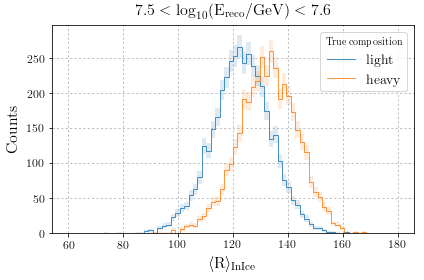

In [18]:
radius_bins = np.linspace(60, 180, 75)

fig, ax = plt.subplots()

# df_sim['log_dEdX'][light_mask & energy_mask].plot(kind='hist', bins=bins, alpha=0.75, label='light', ax=ax)
# df_sim['log_dEdX'][heavy_mask & energy_mask].plot(kind='hist', bins=bins, alpha=0.75, label='heavy', ax=ax)

light_counts = np.histogram(df_sim['avg_inice_radius'][light_mask & energy_mask], radius_bins)[0]
heavy_counts = np.histogram(df_sim['avg_inice_radius'][heavy_mask & energy_mask], radius_bins)[0]

plotting.plot_steps(radius_bins, light_counts, yerr=np.sqrt(light_counts), ax=ax, color='C0', label='light')
plotting.plot_steps(radius_bins, heavy_counts, yerr=np.sqrt(heavy_counts), ax=ax, color='C1', label='heavy')

# ax.set_yscale("log", nonposy='clip')
ax.set_ylabel('Counts')
ax.set_xlabel('$\mathrm{\langle R \\rangle _{InIce}}$')
ax.set_title('$\mathrm{ 7.5 < \\log_{10}(E_{reco}/GeV) < 7.6 }$')
# ax.set_xlim([70, 170])
ax.set_ylim(0)
ax.grid()
ax.legend(title='True composition')
plt.savefig('/home/jbourbeau/public_html/figures/avg-radius-dist-example.png')
plt.show()

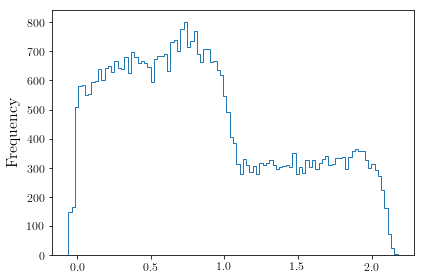

In [19]:
df_sim_train[feature_mask].log_s125.plot(kind='hist', bins=100, histtype='step');

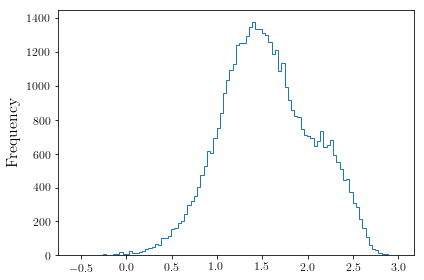

In [20]:
df_sim_train[feature_mask].log_dEdX.plot(kind='hist', bins=100, histtype='step');